# <center>**Word Vectors**</center>

---



##**Definition**

You can try and imagine language as a cloud, with scattered points, where each point is a different word. The location of each point is dependent on the location of every other point in the cloud (eg. if two words share the same context, they should appear near one to another). As long as you can represent a point in space, it gets a computational representation : it becomes a vector in space, a direction. And it becomes possible to compute things from it.

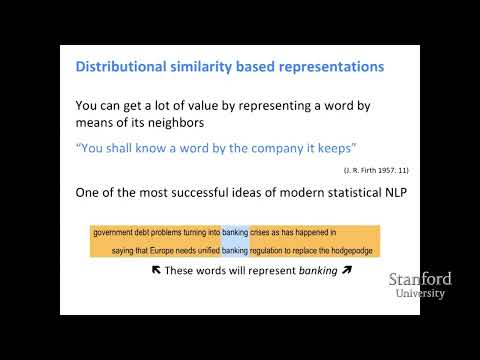

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("ORstNrlG_2g", width=512, height=288)

![](https://drive.google.com/uc?export=view&id=1FsTcOQ5LVgbDqkT5nm_gve5gZfQrZ8pV)

In [1]:
import os
import gensim
from gensim.models import Word2Vec
import glob
import nltk

from lxml import etree as ET
import lxml.html
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!wget https://raw.githubusercontent.com/ABC-DH/EnExDi2024/main/materials/3_NLP/auteurs.zip

In [ ]:
!unzip "/content/auteurs.zip"

In [4]:
dumas="auteurs/flaubert/"
balzac="auteurs/balzac/"

In [5]:
def strip_ns_prefix(tree):
    query = "descendant-or-self::*[namespace-uri()!='']"
    for element in tree.xpath(query):
        element.tag = ET.QName(element).localname
    return tree

In [ ]:
if balzac != "":
    files = glob.iglob(balzac + '/**/*.xml', recursive=True)
    sentences = []

    for filename in files:
        print(filename)
        parser = ET.XMLParser(remove_blank_text=True, resolve_entities=False, encoding='utf8')
        tree = strip_ns_prefix(ET.parse(filename, parser))

        words = tree.xpath(".//wf/@lemma")

        sentence = []
        for word in words:
            if word != ".":
                sentence.append(word)
            else:
                sentences.append(sentence + [word])
                sentence = []

In [ ]:
print(len(sentences))
print(sentences[5])

## Building a model

This part, depending on the amount of data you intend to compute, may take some time (default : 8 minutes)

In [8]:
model = Word2Vec(sentences, min_count=2, max_vocab_size=10000, negative=10, epochs=200)

In [9]:
model.wv.save("/content/model_balzac.bin")

In [ ]:
print(model.wv.index_to_key)

In [ ]:
#Paris is to France what London is to what ? model.wv.most_similar(positive=['Londres', 'France'], negative=['Paris'],topn=5)
#King is to man what Queen is to what ? model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=5)
model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=10)

In [ ]:
model.wv.most_similar('esprit',topn=10)

## Visualization

In [ ]:
!wget https://raw.githubusercontent.com/ABC-DH/EnExDi2024/main/materials/3_NLP/stopwords_fr.txt

In [15]:
stops = open("/content/stopwords_fr.txt", encoding="utf-8").read().split("\n")

In [16]:
from sklearn.manifold import TSNE
import plotly.express as px

In [17]:
nb_mots_a_visualiser = 500
words = [word for word in model.wv.index_to_key if word not in stops and word not in string.punctuation][:500]
word_vectors = np.array([model.wv[word] for word in words])

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200,random_state=0)
vectors_3d = tsne.fit_transform(word_vectors)

import pandas as pd
df = pd.DataFrame(vectors_3d, columns=['x', 'y', 'z'])
df['word'] = words

fig = px.scatter_3d(df, x='x', y='y', z='z', text='word', title="3D Visualization for W2V vectors")
fig.show()

In [ ]:
fig.write_html("/content/word2vec_visualization.html")

## Visualization with Tensorflow
You can also get a much clearer visualization using the [online tensorflow visualizer](https://projector.tensorflow.org/). After this next cell, you'll get two files, one containing the vectors, the other their labels.

In [13]:
with open("vecteurs.tsv", 'w') as file_vectors, open("metadonnees.tsv", 'w') as file_metadata:
    for word in model.wv.index_to_key:
        file_vectors.write('\t'.join([str(x) for x in model.wv[word]]) + "\n")
        file_metadata.write(word + "\n")